# Using elasticsearch fuzzy match and machine learning methods to categorise short text descriptions

Prerequisites:
- setup virtual env: `python -m venv <your_new_virtual_environment_name>`
- activate virtual env: `source <your_new_virtual_environment_name>`
- clone and install this repo `pip install git+https://github.com/chilledgeek/elasticsearch-simple-client.git`
- install extra packages for machine learning: `pip install tensorflow matplotlib scikit-learn xgboost`
- have a running elasticsearch docker image: 
  - `sudo docker pull elasticsearch:7.5.2`
  - `sudo docker run -d --name elasticsearch -p 9200:9200 -p 9300:9300 -e "discovery.type=single-node" elasticsearch:7.5.2` 
  - (`-d` runs command line in background)
- If required, clear out previous data on elasticsearch with: `curl -X DELETE "localhost:9200/<index_name>"`

In [1]:
!curl -X DELETE "localhost:9200/simple_text"

{"acknowledged":true}

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Data preparation (mainly for machine learning techniques)

### Load data

In [3]:
import pandas as pd

filepath = "./descriptions_with_categories.csv"
df = pd.read_csv(filepath)
df.head()

,description,annotated_category
0,ABOKADO HOLBORN LONDON GBR,EAT OUT
1,ABOKADO LONDON WCXV,EAT OUT
2,ACCOUNT TRANSFER,BANK TRANSFER
3,ADDED GROSS INT,INTEREST
4,ADDED NET INT,INTEREST


#### Filter out categories that have less than 10 annotated entries

In [4]:
indices_of_interest = df["annotated_category"].value_counts()[df["annotated_category"].value_counts() >= 10 ].index

In [5]:
df = df[df["annotated_category"].isin(indices_of_interest)]

### Label encode categories and apply to category

In [6]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(["UNKNOWN"] + list(df["annotated_category"])) # Add an extra UNKNOWN label in case outcome cannot be predicted

LabelEncoder()

In [7]:
df["annotated_category (encoded)"] = le.transform(df["annotated_category"])
df.head()

,description,annotated_category,annotated_category (encoded)
0,ABOKADO HOLBORN LONDON GBR,EAT OUT,3
1,ABOKADO LONDON WCXV,EAT OUT,3
2,ACCOUNT TRANSFER,BANK TRANSFER,0
6,ADVICE CONFIRMS GBSXXXXXAOSZK SURNAME NAME,BANK TRANSFER,0
7,ADVICE CONFIRMS GBSXXXXXALEVX SURNAME NAME,BANK TRANSFER,0


### Split data to train and test sets

In [8]:
raw_train = df.sample(frac=0.8).sort_index()
raw_train.head()

,description,annotated_category,annotated_category (encoded)
0,ABOKADO HOLBORN LONDON GBR,EAT OUT,3
1,ABOKADO LONDON WCXV,EAT OUT,3
2,ACCOUNT TRANSFER,BANK TRANSFER,0
6,ADVICE CONFIRMS GBSXXXXXAOSZK SURNAME NAME,BANK TRANSFER,0
7,ADVICE CONFIRMS GBSXXXXXALEVX SURNAME NAME,BANK TRANSFER,0


In [9]:
raw_test = df[~df.index.isin(raw_train.index)]
raw_test.head()

,description,annotated_category,annotated_category (encoded)
11,ALDI CANTERBURY,GROCERIES,6
36,ANSTRUTHER FISH BAR AND ANSTRUTHER GBR,EAT OUT,3
39,APPLE ITUNES STORE GBP LUXEMBURG,ENTERTAINMENT,4
43,ARGOS LTD CAMBRIDGE,HOUSEHOLD,8
47,ARGOS UNKNOWN,HOUSEHOLD,8


In [10]:
print(f"training entries: {len(raw_train)}")
print(f"test entries: {len(raw_test)}")
print(f"number of unique categories (with enough annotations): {len(set(df['annotated_category']))}")

training entries: 301
test entries: 75
number of unique categories (with enough annotations): 12


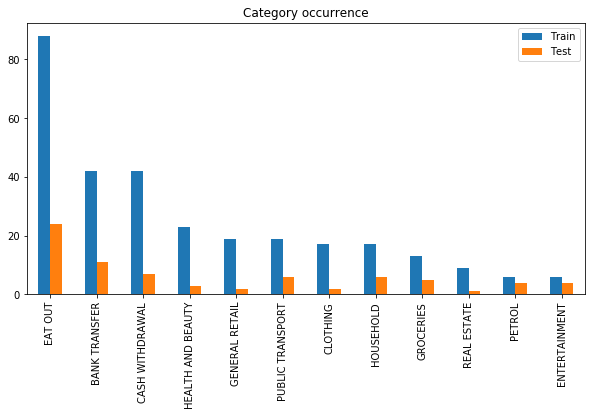

In [11]:
accumulated_category_count_df = pd.concat([
    raw_train["annotated_category"].value_counts(),
    raw_test["annotated_category"].value_counts()], 
    axis=1, 
    sort=False,
    keys = ["Train", "Test"])
accumulated_category_count_df.plot(kind="bar", figsize=(10,5), title="Category occurrence")

#### Create a bag of words using a count vectorizer

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

desc_vectorizer = CountVectorizer(analyzer="word", max_features=100)

training_bag_of_words = desc_vectorizer.fit_transform(raw_train["description"])

x_train = pd.DataFrame(training_bag_of_words.toarray(),
                       columns=[x for x in desc_vectorizer.get_feature_names()]).astype(int)

x_train.head()

,advice,amazon,and,aprxx,argos,asda,ashford,augxx,bar,barclays,...,trm,uk,wcxr,west,wharf,xx,xxx,xxxx,xxxxxx,xxxxxxxxxxxxxxxxxn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
test_bag_of_words = desc_vectorizer.transform(raw_test["description"])

x_test = pd.DataFrame(test_bag_of_words.toarray(),
                      columns=[x for x in desc_vectorizer.get_feature_names()]).astype(int)
x_test.head()

,advice,amazon,and,aprxx,argos,asda,ashford,augxx,bar,barclays,...,trm,uk,wcxr,west,wharf,xx,xxx,xxxx,xxxxxx,xxxxxxxxxxxxxxxxxn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")

Shape of x_train: (301, 100)
Shape of x_test: (75, 100)


## Model building

### Neural Network

In [15]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Input(shape=(100,)),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(len(set(df["annotated_category"])) + 1, activation='softmax') # extra unit for "UNKNOWN" tag
])

/home/dino/venv/test_es/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dino/venv/test_es/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dino/venv/test_es/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dino/venv/test_es/lib/python3.6/site-packages/tensorflow/python/framework

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/home/dino/venv/test_es/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dino/venv/test_es/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dino/venv/test_es/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dino/venv/test_es/lib/python3.6/site-packages/tensor

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.fit(x_train.values, raw_train["annotated_category (encoded)"], epochs=100)

Epoch 1/100
301/301 [==============================] - 0s 448us/sample - loss: 2.5674 - acc: 0.0532
Epoch 2/100
301/301 [==============================] - 0s 120us/sample - loss: 2.5646 - acc: 0.0930
Epoch 3/100
301/301 [==============================] - 0s 102us/sample - loss: 2.5618 - acc: 0.1694
Epoch 4/100
301/301 [==============================] - 0s 103us/sample - loss: 2.5588 - acc: 0.2326
Epoch 5/100
301/301 [==============================] - 0s 101us/sample - loss: 2.5555 - acc: 0.2791
Epoch 6/100
301/301 [==============================] - 0s 127us/sample - loss: 2.5521 - acc: 0.3189
Epoch 7/100
301/301 [==============================] - 0s 109us/sample - loss: 2.5481 - acc: 0.3555
Epoch 8/100
301/301 [==============================] - 0s 109us/sample - loss: 2.5432 - acc: 0.3754
Epoch 9/100
301/301 [==============================] - 0s 119us/sample - loss: 2.5376 - acc: 0.3920
Epoch 10/100
301/301 [==============================] - 0s 96us/sample - loss: 2.5304 - acc: 0.4053


301/301 [==============================] - 0s 100us/sample - loss: 1.9395 - acc: 0.7708
Epoch 83/100
301/301 [==============================] - 0s 112us/sample - loss: 1.9380 - acc: 0.7708
Epoch 84/100
301/301 [==============================] - 0s 93us/sample - loss: 1.9366 - acc: 0.7741
Epoch 85/100
301/301 [==============================] - 0s 98us/sample - loss: 1.9352 - acc: 0.7741
Epoch 86/100
301/301 [==============================] - 0s 85us/sample - loss: 1.9338 - acc: 0.7741
Epoch 87/100
301/301 [==============================] - 0s 84us/sample - loss: 1.9324 - acc: 0.7741
Epoch 88/100
301/301 [==============================] - 0s 84us/sample - loss: 1.9310 - acc: 0.7741
Epoch 89/100
301/301 [==============================] - 0s 90us/sample - loss: 1.9297 - acc: 0.7741
Epoch 90/100
301/301 [==============================] - 0s 105us/sample - loss: 1.9281 - acc: 0.7741
Epoch 91/100
301/301 [==============================] - 0s 85us/sample - loss: 1.9267 - acc: 0.7774
Epoch 92/1

### Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train, raw_train["annotated_category (encoded)"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### XGBoost

In [19]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(x_train, raw_train["annotated_category (encoded)"])

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

### Elasticsearch

##### Upload training data (descriptions + category) to elasticsearch

In [20]:
from elasticsearch_simple_client.uploader import Uploader

es_uploader = Uploader()
es_uploader.post_df(raw_train[["description","annotated_category"]])

#### Query test data and lookup nearest (fuzzy) match to training data and get corresponding category

In [21]:
import time
time.sleep(5) # allow time for elasticsearch indices to be updated

In [22]:
from elasticsearch_simple_client.searcher import Searcher

searcher = Searcher()
es_category_lookup_on_train_data = []

for entry in raw_train["description"]:
    result = searcher.execute_search(field="description",
                                     shoulds=[entry])["hits"]["hits"]
    predicted_category = result[0]["_source"]["annotated_category"]
    es_category_lookup_on_train_data.append(predicted_category)

In [23]:
es_category_lookup_on_test_data = []

for entry in raw_test["description"]:
    result = searcher.execute_search(field="description",
                                     shoulds=[entry])["hits"]["hits"]
    if len(result) > 0:
        es_category_lookup_on_test_data.append(result[0]["_source"]["annotated_category"])
    else:
        es_category_lookup_on_test_data.append("UNKNOWN")

## Analysis

In [24]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [25]:
def analysis_result(model_name, 
                    train_prediction,
                    train_target,
                    test_prediction, 
                    test_target):
    results = dict()
    results["model"] = model_name
    results["train_accuracy"] = accuracy_score(train_prediction, train_target)
    results["balanced_train_accuracy"] = balanced_accuracy_score(train_prediction, train_target)
    results["test_accuracy"] = accuracy_score(test_prediction, test_target)
    results["balanced_test_accuracy"] = balanced_accuracy_score(test_prediction, test_target)

    for key, value in results.items():
        if isinstance(value, str):
            print(f"\n{value}")
        else:
            print(f"\t{key}: {'{:.2f}'.format(value)}")
    
    return results

In [26]:
accumulated_results = []

train_pred_nn = [list(x).index(max(x)) for x in model.predict(x_train)]
test_pred_nn = [list(x).index(max(x)) for x in model.predict(x_test)]

accumulated_results.append(analysis_result("Neural Network", 
                                           train_pred_nn, 
                                           raw_train['annotated_category (encoded)'],               
                                           test_pred_nn, 
                                           raw_test['annotated_category (encoded)']))

train_pred_rf = rf.predict(x_train)
test_pred_rf = rf.predict(x_test)

accumulated_results.append(analysis_result("Random Forest", 
                                           train_pred_rf, 
                                           raw_train['annotated_category (encoded)'],
                                           test_pred_rf, 
                                           raw_test['annotated_category (encoded)']))

train_pred_xgb = xgb.predict(x_train)
test_pred_xgb = xgb.predict(x_test)

accumulated_results.append(analysis_result("XGBoost", 
                                           train_pred_xgb, 
                                           raw_train['annotated_category (encoded)'],
                                           test_pred_xgb, 
                                           raw_test['annotated_category (encoded)']))

train_pred_es = le.transform(es_category_lookup_on_train_data)
test_pred_es = le.transform(es_category_lookup_on_test_data)

accumulated_results.append(analysis_result("Elasticsearch", 
                                           train_pred_es, 
                                           raw_train['annotated_category (encoded)'],
                                           test_pred_es, 
                                           raw_test['annotated_category (encoded)']))


Neural Network
	train_accuracy: 0.80
	balanced_train_accuracy: 0.88
	test_accuracy: 0.69
	balanced_test_accuracy: 0.74

Random Forest
	train_accuracy: 0.93
	balanced_train_accuracy: 0.95
	test_accuracy: 0.61
	balanced_test_accuracy: 0.64

XGBoost
	train_accuracy: 0.88
	balanced_train_accuracy: 0.95
	test_accuracy: 0.65
	balanced_test_accuracy: 0.71

Elasticsearch
	train_accuracy: 1.00
	balanced_train_accuracy: 1.00
	test_accuracy: 0.76
	balanced_test_accuracy: 0.76


/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/dino/venv/test_es/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


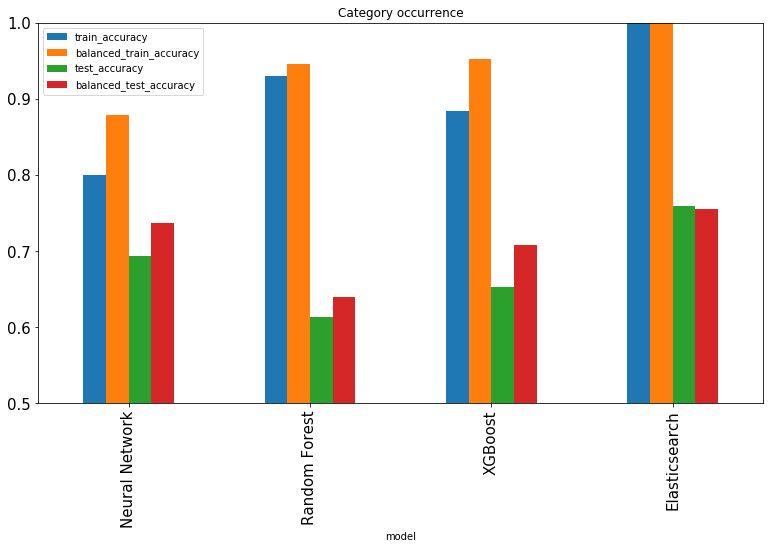

In [27]:
model_results_df = pd.DataFrame(accumulated_results)
model_results_df.set_index("model").plot(
    kind="bar", figsize=(13,7), ylim=(0.5,1), fontsize=15, title="Category occurrence"
)

In [28]:
raw_train.loc[:,"nn_prediction"] = le.inverse_transform(train_pred_nn)
raw_test.loc[:,"nn_prediction"] = le.inverse_transform(test_pred_nn)

raw_train.loc[:,"rf_prediction"] = le.inverse_transform(train_pred_rf)
raw_test.loc[:,"rf_prediction"] = le.inverse_transform(test_pred_rf)

raw_train.loc[:,"xgb_prediction"] = le.inverse_transform(train_pred_xgb)
raw_test.loc[:,"xgb_prediction"] = le.inverse_transform(test_pred_xgb)

raw_train.loc[:,"es_prediction"] = es_category_lookup_on_train_data
raw_test.loc[:,"es_prediction"] = es_category_lookup_on_test_data

/home/dino/venv/test_es/lib/python3.6/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dino/venv/test_es/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [29]:
view_columns = [x for x in raw_train.keys() if x != "annotated_category (encoded)"]

In [30]:
raw_train[view_columns].head(10)

,description,annotated_category,nn_prediction,rf_prediction,xgb_prediction,es_prediction
0,ABOKADO HOLBORN LONDON GBR,EAT OUT,EAT OUT,EAT OUT,EAT OUT,EAT OUT
1,ABOKADO LONDON WCXV,EAT OUT,EAT OUT,EAT OUT,EAT OUT,EAT OUT
2,ACCOUNT TRANSFER,BANK TRANSFER,EAT OUT,EAT OUT,EAT OUT,BANK TRANSFER
6,ADVICE CONFIRMS GBSXXXXXAOSZK SURNAME NAME,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
7,ADVICE CONFIRMS GBSXXXXXALEVX SURNAME NAME,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
8,ADVICE CONFIRMS GBSXXXXXXXXCG SURNAME NAME,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
9,ADVICE CONFIRMS GBSXXXXXXXXHC SURNAME NAME,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
10,ALDI,GROCERIES,EAT OUT,EAT OUT,EAT OUT,GROCERIES
12,SURNAME INITIALS BAKING FP XX/XX/XX XXXX RPXXX...,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
13,SURNAME INITIALS CIGGIES FP XX/XX/XX XXXX RPXX...,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER


In [31]:
raw_test[view_columns].head(10)

,description,annotated_category,nn_prediction,rf_prediction,xgb_prediction,es_prediction
11,ALDI CANTERBURY,GROCERIES,EAT OUT,CLOTHING,CLOTHING,GROCERIES
36,ANSTRUTHER FISH BAR AND ANSTRUTHER GBR,EAT OUT,EAT OUT,EAT OUT,EAT OUT,EAT OUT
39,APPLE ITUNES STORE GBP LUXEMBURG,ENTERTAINMENT,EAT OUT,EAT OUT,EAT OUT,GROCERIES
43,ARGOS LTD CAMBRIDGE,HOUSEHOLD,EAT OUT,HOUSEHOLD,HOUSEHOLD,HOUSEHOLD
47,ARGOS UNKNOWN,HOUSEHOLD,HOUSEHOLD,HOUSEHOLD,HOUSEHOLD,HOUSEHOLD
48,AROMI CAFFE LTD CAMBRIDGE GBR,EAT OUT,EAT OUT,HOUSEHOLD,HOUSEHOLD,HOUSEHOLD
52,ASDA FILLING STATION U CANTERBURY,PETROL,GROCERIES,GROCERIES,GROCERIES,GROCERIES
54,ASDA PETROL/UPT XXXX CANTERBURY GBR,PETROL,HEALTH AND BEAUTY,GROCERIES,GROCERIES,GROCERIES
59,ASOS.COM LIMITED LONDO LONDON,CLOTHING,EAT OUT,EAT OUT,EAT OUT,EAT OUT
62,AX SOUTHBOUND GRANTHAM PROCESS DATE XX/XX/XXXX...,EAT OUT,HEALTH AND BEAUTY,HOUSEHOLD,HOUSEHOLD,HOUSEHOLD


In [32]:
raw_train[view_columns].sample(n=20)

,description,annotated_category,nn_prediction,rf_prediction,xgb_prediction,es_prediction
81,BARCLAYS BNK XXJAN,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
406,JOHN LEWIS AT HOME LONDON,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL
273,CLACKET LANE WEST CONNE WESTERHAM,EAT OUT,EAT OUT,EAT OUT,EAT OUT,EAT OUT
77,BARCLAYS BNK XXAPR,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
449,MANGO.COM BARCELONA,CLOTHING,EAT OUT,EAT OUT,EAT OUT,CLOTHING
446,LUMINUS HOMES LTD,REAL ESTATE,EAT OUT,EAT OUT,EAT OUT,REAL ESTATE
441,LUL TICKET MACHINE-LEIC LONDON,PUBLIC TRANSPORT,PUBLIC TRANSPORT,PUBLIC TRANSPORT,PUBLIC TRANSPORT,PUBLIC TRANSPORT
263,SURNAME INITIALS NATWEST MONEY,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
276,CLINTON CARDS XXXX CAMBRIDGE GBR,EAT OUT,HEALTH AND BEAUTY,EAT OUT,EAT OUT,EAT OUT
7,ADVICE CONFIRMS GBSXXXXXALEVX SURNAME NAME,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER


In [33]:
raw_test[view_columns].sample(n=20)

,description,annotated_category,nn_prediction,rf_prediction,xgb_prediction,es_prediction
261,SURNAME INITIALS RSB HSBC REG SAVER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
157,CALL REF.NO. XXXX SURNAME INITIALS FP XX/XX/XX...,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
348,EURL CLARA ROUEN FRA XX.XX EUR,PUBLIC TRANSPORT,CASH WITHDRAWAL,CASH WITHDRAWAL,HOUSEHOLD,GENERAL RETAIL
429,LUL TICKET MACHINE CHANCERY LANE,PUBLIC TRANSPORT,PUBLIC TRANSPORT,PUBLIC TRANSPORT,PUBLIC TRANSPORT,PUBLIC TRANSPORT
410,JOHN LEWIS OXFORD STREE LONDON,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL,GENERAL RETAIL
245,CHIQUITO CAMBRIDGE,EAT OUT,EAT OUT,GROCERIES,EAT OUT,EAT OUT
159,CALL REF.NO. XXXX FROM A/C XXXXXXXX,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER,BANK TRANSFER
107,BMS WWW.LOOKFANTASTIC.COM PROCESS DATE XX/XX/X...,CLOTHING,HEALTH AND BEAUTY,HOUSEHOLD,HOUSEHOLD,HOUSEHOLD
451,MARKS & SPENCER MOTO SC RICHMOND,EAT OUT,EAT OUT,EAT OUT,EAT OUT,EAT OUT
242,CHIANG MAI KITCHEN OXFORD GBR,EAT OUT,EAT OUT,CLOTHING,EAT OUT,GROCERIES
